In this ongoing project, I explore different methods for analyzing the sentiment of Amazon product reviews. I employ a dataset of text reviews and corresponding products ratings assigned by each reviewer as labelled training data, and predict product ratings on a test data set. I compare the predictive power of different approaches to text preprocessing with both naïve Bayes and support vector machine (SVM) models.

# Load and Tidy Data

I first need to import the packages I will use.

In [16]:
import pandas as pd
import ast
import time
import re
import scipy

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import svm

%matplotlib inline

I will use data from Julian McAuley's [Amazon product dataset](http://jmcauley.ucsd.edu/data/amazon/). To begin, I will use the [subset of Toys and Games data](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz). Start by loading the dataset.

In [ ]:
# # read entire file
# with open('reviews_Toys_and_Games_5.json', 'rb') as f:
#     data = f.readlines()
    
# # remove the trailing "\n" from each element
# data = map(lambda x: x.rstrip(), data)
# print 'number reviews:', len(data)

# # for now, let's restrict to the first 30k obs
# # (if I want to run with the full dataset, will probably need to use ec2)
# data = data[:50000]

# # convert list to a dataframe
# t1 = time.time()
# df = pd.DataFrame()
# count = 0
# for r in data:
#     r = ast.literal_eval(r)
#     s  = pd.Series(r,index=r.keys())
#     df = df.append(s,ignore_index=True)
#     if count % 1000 ==0:
#         print count
#     count+=1
# t_process = time.time() - t1
# print 'process time (seconds):', t_process  #takes 8s for 1000, so should take 8*167/60=22min for 167k
# del data

# # the above step is slow, so let's write this to csv so we don't have to do it again
# df.to_csv('Toys_and_Games.csv', index=False)

In [6]:
df = pd.read_csv('Toys_and_Games.csv')
print df.shape
print df.head(3)

(50000, 9)
         asin helpful  overall  \
0  0439893577  [0, 0]      5.0   
1  0439893577  [1, 1]      4.0   
2  0439893577  [1, 1]      5.0   

                                          reviewText   reviewTime  \
0  I like the item pricing. My granddaughter want...  01 29, 2014   
1  Love the magnet easel... great for moving to d...  03 28, 2014   
2  Both sides are magnetic.  A real plus when you...  01 28, 2013   

       reviewerID    reviewerName  \
0  A1VXOAVRGKGEAK           Angie   
1   A8R62G708TSCM         Candace   
2  A21KH420DK0ICA  capemaychristy   

                                             summary  unixReviewTime  
0                                     Magnetic board    1.390954e+09  
1  it works pretty good for moving to different a...    1.395965e+09  
2                                         love this!    1.359331e+09  


# Descriptive Statistics

Let's take a look at the distribution of scores across reviews.

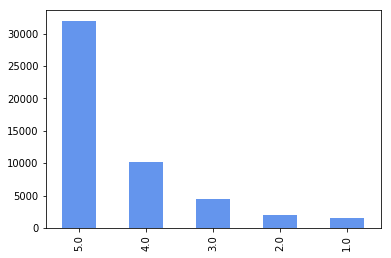

In [7]:
df['overall'].value_counts().plot(kind='bar', color='cornflowerblue')

# Naive Bayes

Naive Bayes, in short, uses Bayes rule to find the most likely class for each document. In order to do this it makes a couple of strong assumptions that it is worth being aware of: the position of each word in a document doesn't matter (bag of words), and feature probabilities are independent given the class (conditional independence). Jurafsky and Manning have a great introduction to [Naive Bayes and sentiment analysis](https://www.youtube.com/watch?v=c3fnHA6yLeY&list=PL6397E4B26D00A269&index=24). Kevin Markham has [slides](https://github.com/justmarkham/pycon-2016-tutorial) and accompanying [talk](https://www.youtube.com/watch?v=WHocRqT-KkU) that give an introduction to Naive Bayes in scikit-learn.

First, drop observations containg NaN in review or star rating.

In [8]:
print len(df)
df = df[df['reviewText'].notnull()]
print len(df)
df = df[df['overall'].notnull()]
print len(df)

50000
49973
49973


Split into test and training data.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], 
                                                   df['overall'],
                                                   test_size=.2, random_state=1)

I am going to represent each review as a bag of words, that is, a count of how many times each word appears in a document. Therefore, convert the collection of training reviews into a collection of token counts (a document term matrix).

In [10]:
# instantiate the vectorizer
vect = CountVectorizer()

# tokenize train and test text data
X_train_dtm = vect.fit_transform(X_train)
print "number words in training corpus:", len(vect.get_feature_names())
X_test_dtm = vect.transform(X_test)

number words in training corpus: 36897


Instantiate and train a multinomial naive Bayes model.

In [ ]:
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)

Evaluate the model.

In [ ]:
# make class predictions
y_pred = nb.predict(X_test_dtm)

# calculate accuracy, precision, recall, and F-measure of class predictions
def eval_predictions(y_test, y_pred):
    print 'accuracy:', metrics.accuracy_score(y_test, y_pred)
    print 'precision:', metrics.precision_score(y_test, y_pred, average='weighted')
    print 'recall:', metrics.recall_score(y_test, y_pred, average='weighted')
    print 'F-measure:', metrics.f1_score(y_test, y_pred, average='weighted')
eval_predictions(y_test, y_pred)

Take a look at examples where the model is getting it wrong.

In [ ]:
# print message text for the first 3 false positives
print 'False positives:'
print
for x in X_test[y_test < y_pred][:2]:
    print x
    print

# print message text for the first 3 false negatives
print 'False negatives:'
print
for x in X_test[y_test > y_pred][:2]:
    print x[:500]
    print

# Improving Preprocessing

Tokenization is usually accompanied by other preprocessing steps, such as:
<ol>
<li><i>Make all words lowercase</i></li>
<li><i>Remove punctuation</i></li>
<li><i>Tokenize</i>: divide string into a list of substrings.</li>
<li><i>Remove words not containing letters</i></li>
<li><i>Remove words containing numbers</i></li>
<li><i>Remove stopwords</i>: stopwords are a list of high frequency words like, the, to, and also.</li>
<li><i>Lemmatize</i>: reduces the dimension of the data by aggregating words that either are the same root or have the same meaning.</li>
</ol>

Let's try including some of these steps and see if it improves our model.

In [11]:
import string
import nltk
from nltk.stem import WordNetLemmatizer

def no_punctuation_unicode(text):
    '''.translate only takes str. Therefore, to use .translate in the 
    tokenizer in TfidfVectorizer I need to write a function that converts 
    unicode -> string, applies .translate, and then converts it back'''
    str_text = str(text)
    no_punctuation = str_text.translate(None, string.punctuation)
    unicode_text = no_punctuation.decode('utf-8')
    return unicode_text

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

stoplist = [word.decode('utf-8') for word in nltk.corpus.stopwords.words('english')] 

wnl = WordNetLemmatizer()

def prep_review(review):
    lower_case = review.lower()
    no_punct = no_punctuation_unicode(lower_case)
    tokens = nltk.word_tokenize(no_punct)    # weird to tokenize within the vectorizer, 
    # but not sure how else to apply functions to each token
    has_letters = [t for t in tokens if re.search('[a-zA-Z]',t)]
    drop_numbers  = [t for t in has_letters if not hasNumbers(t)]
    drop_stops = [t for t in drop_numbers if not t in stoplist] 
    lemmed = [wnl.lemmatize(word) for word in drop_stops]
    return lemmed

# tokenize train and test text data
vect = CountVectorizer(tokenizer=prep_review)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

KeyboardInterrupt: 

In [ ]:
# instantiate and train model
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)

# evaluate model
y_pred = nb.predict(X_test_dtm)
eval_predictions(y_test, y_pred)

The extra preprocessing has little effect. In fact, our original approach did slightly better. But can we improve with a different algorithm?

# Support Vector Machines

I will also try classifying the reviews using SVMs, which perform classification by constructing hyperplanes to separate different classes. In constructing the hyperplanes, SVMs try firstly to classify observations correctly, and subject to this constraint seek to maximize the margin (the distance between the hyperplane and the nearest point).

I start by creating a TF-IDF matrix. Rather than just measuring the number of times a word appears in a document, as we did above, we now multiply this by the inverse document frequency (the inverse of the number of documents the words appears in). Thus, a words TF-IDF is a measure of relevance. As above, I will initially use limited preprocessing.

In [12]:
tfidf_vectorizer_1 = TfidfVectorizer(min_df=5, max_df=0.8)
tfidf_train_1 = tfidf_vectorizer_1.fit_transform(X_train)
tfidf_test_1 = tfidf_vectorizer_1.transform(X_test)

SVM is a classifier built on giving us linear separation. Kernels are the main technique for adapting SVMs to develop non-linear classifiers, by taking a low-dimensional input space and mapping it to a higher dimensional space. Let’s try SVM with both a linear kernel and an rbf (Gaussian) kernel that maps the features to a higher dimensional space.

In [ ]:
# instantiate and train model, kernel=rbf 
svm_rbf = svm.SVC(random_state=12345)
%time svm_rbf.fit(tfidf_train_1, y_train)

# evaulate model
y_pred_1 = svm_rbf.predict(tfidf_test_1)
eval_predictions(y_test, y_pred_1)

In [ ]:
# instantiate and train model, kernel=linear
svm_rbf = svm.SVC(kernel='linear', random_state=12345)
%time svm_rbf.fit(tfidf_train_1, y_train)

# evaulate model
y_pred_1 = svm_rbf.predict(tfidf_test_1)
eval_predictions(y_test, y_pred_1)

Now let's try with the more extensive preprocessing that we used above.

In [ ]:
tfidf_vectorizer_2 = TfidfVectorizer(tokenizer=prep_review, min_df=5, max_df=0.8)
tfidf_train_2 = tfidf_vectorizer_2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer_2.transform(X_test)

# kernel=rbf
print 'kernel=rbf'
svm_rbf = svm.SVC(random_state=1)
%time svm_rbf.fit(tfidf_train_2, y_train)
y_pred_2 = svm_rbf.predict(tfidf_test_2)
eval_predictions(y_test, y_pred_2)
print 

print 'kernel=linear'
svm_rbf = svm.SVC(kernel='linear', random_state=1)
%time svm_rbf.fit(tfidf_train_2, y_train)
y_pred_2 = svm_rbf.predict(tfidf_test_2)
eval_predictions(y_test, y_pred_2)

It is suprising that with an rbf kernel we get exactly the same performance with and without the extra preprocessing steps. I have recoded the variables to ensure I'm not accidentally repeating anything. Let's also print the two vectorizers to check that they are in fact different.

In [ ]:
compare_tokens = pd.DataFrame(
    {'unprocessed': tfidf_vectorizer_1.get_feature_names()[:10],
     'preprocessed': tfidf_vectorizer_2.get_feature_names()[:10],
    })
compare_tokens

We see that the linear kernel performs best across all predictive measures, and that we actually get slightly better performance without preprocessing. Linear kernels often perform well with text classification because when there are a lot of features, mapping the data to a higher dimensional space [does little to improve performance](http://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/).

Can we do better using grid search to optimze the hyperparameters of the model?

In [ ]:
# randomized search
param_dist = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1)}
n_iter_search = 1
rand_search = RandomizedSearchCV(svm.SVC(random_state=1), param_dist, cv=5, n_iter=n_iter_search)
rand_search.fit(tfidf_train_1, y_train)
bp = rand_search.best_params_
print 'Best parameters:', bp

# fit and evaluate model with parameters from grid search
model = svm.SVC(C = bp['C'], gamma = bp['gamma'], random_state=1)
model.fit(tfidf_train_1, y_train)
y_pred = model.predict(tfidf_test_1)
eval_predictions(y_test, y_pred)

# Conclusions

The most striking findings here are that it preprocessing makes little difference to the performance of our algorithms and that both naive Bayes and SVMs perform similarly to one another. The latter finding, in particular, is a surprise. Whilst previous research by [Banko and Brill](http://ucrel.lancs.ac.uk/acl/P/P01/P01-1005.pdf) has shown that classifiers perform similarly to one another on extremely large corpora, I was not expecting such similar results with our relatively small sample.

If I have time to pursue this project further, there are a number of steps I would like to take:
* explore how unusual it is to have these different models and classifiers perform so similarly, and triple-check that there is no issue with my code
* improve my classifiers, starting by looking at examples that are misclassified
* experiment with other classifiers
* run my models with a larger dataset, ideally, with 142.8 million reviews in McAuley's full dataset